# Modeling

In [1]:
import pandas as pd
import sklearn 
import psycopg2
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import requests
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

In [2]:
plt.style.use('ggplot')

## load data

In [3]:
# Connect to your postgres DB
conn = psycopg2.connect(
    dbname="olap",
    user="dsp",
    password="dsppassword",
    host="localhost",
    port="5432")

# Open a cursor to perform database operations
cur = conn.cursor()

# Execute a query
cur.execute("SELECT * FROM ctr")

# Retrieve query results
ctr_records = cur.fetchall()
cur.close()
conn.close()

In [4]:
ctr_data = pd.DataFrame(
    ctr_records, 
    columns=[
        "ad_id",
        "status",
        "bidding_cpc",
        "advertiser",
        "banner_style",
        "category",
        "height",
        "width",
        "item_price",
        "layout_style",
        "hist_ctr",
        "hist_cvr",
        "was_click"
    ]
)

In [5]:
ctr_data.head()

,ad_id,status,bidding_cpc,advertiser,banner_style,category,height,width,item_price,layout_style,hist_ctr,hist_cvr,was_click
0,1228,False,1,QQ,VII,Pullover,27.341917,617.51630,2896.4370,MP,0.000366,0.000068,False
1,1792,False,1,AAT,X,Trouser,92.063240,214.45262,2090.9883,CP,0.000617,0.000140,False
2,1072,True,1,WKN,VII,Bag,53.559074,632.53990,1267.7264,HU,0.043057,0.000114,False
3,351,True,2,DQT,XV,Coat,15.722390,707.97230,625.4798,BE,0.001542,0.000020,False
4,1764,True,2,WCI,IX,Trouser,6.916314,393.05652,2707.3628,TX,0.014159,0.000194,False


In [6]:
np.mean(ctr_data["hist_ctr"])

0.0099052038387001

## choice top 10 feature from correlation

In [7]:
numerical_features = ["bidding_cpc", "height", "width", "item_price", "hist_ctr", "hist_cvr"]
categorical_features = ["banner_style", "category", "layout_style"]
target_features = ["was_click"]

In [8]:
formated_data = pd.concat(
    [
        pd.get_dummies(ctr_data[categorical_features]), 
        ctr_data[numerical_features],
        ctr_data[target_features]
    ],  axis=1)

In [9]:
correlation_matrix = formated_data.corr()

In [10]:
correlation_matrix["was_click_abs"] = abs(correlation_matrix["was_click"])

In [11]:
correlation_matrix["was_click_abs"].sort_values(ascending=False).head(11)

was_click          1.000000
layout_style_AB    0.010976
layout_style_RU    0.005915
layout_style_GY    0.005826
layout_style_MR    0.005815
layout_style_BK    0.005572
layout_style_BX    0.005548
layout_style_RZ    0.005274
layout_style_TY    0.005184
category_Shirt     0.005042
layout_style_DX    0.004874
Name: was_click_abs, dtype: float64

In [12]:
decided_features = list(correlation_matrix["was_click_abs"].sort_values(ascending=False).head(11).index)[1:]
print(decided_features)

['layout_style_AB', 'layout_style_RU', 'layout_style_GY', 'layout_style_MR', 'layout_style_BK', 'layout_style_BX', 'layout_style_RZ', 'layout_style_TY', 'category_Shirt', 'layout_style_DX']


## Create features on feature store

In [13]:
# check feature store server
response = requests.get("http://localhost:8000/health")
print(response.json())

True


In [14]:
# create feature store
feature_store_name = "mini-demand-side-platform"
offline_table_name = "top_10_features"
feature_store_description = "choice top 10 feature from correlation"
response = requests.post(
    "http://localhost:8000/feature_store", 
    json={
        "feature_store_name": feature_store_name,
        "offline_table_name": offline_table_name,
        "description": feature_store_description
    })
feature_store_id = response.json()
print(feature_store_id)

cdc74d4c


In [15]:
# create features
for decided_feature in decided_features:
    print("feature_name: ", decided_feature)
    mapping_value = decided_feature.split("_")[-1]
    original_column_name = "_".join(decided_feature.split("_")[:-1])
    payload = {
        "feature_name": decided_feature,
        "source_table_name": "ctr",
        "source_column_name": original_column_name,
        "function_name": decided_feature,
        "description": "map {column} {target} to 1".format(
            column=original_column_name, 
            target=mapping_value),
        "mapping_rules": {mapping_value: 1, "default": 0}
    }
    print("create feature payload: ", payload)
    response = requests.post(
        "http://localhost:8000/feature_store/{feature_store_id}/feature/string_mapping".format(
            feature_store_id=feature_store_id),
        json=payload)


feature_name:  layout_style_AB
create feature payload:  {'feature_name': 'layout_style_AB', 'source_table_name': 'ctr', 'source_column_name': 'layout_style', 'function_name': 'layout_style_AB', 'description': 'map layout_style AB to 1', 'mapping_rules': {'AB': 1, 'default': 0}}
feature_name:  layout_style_RU
create feature payload:  {'feature_name': 'layout_style_RU', 'source_table_name': 'ctr', 'source_column_name': 'layout_style', 'function_name': 'layout_style_RU', 'description': 'map layout_style RU to 1', 'mapping_rules': {'RU': 1, 'default': 0}}
feature_name:  layout_style_GY
create feature payload:  {'feature_name': 'layout_style_GY', 'source_table_name': 'ctr', 'source_column_name': 'layout_style', 'function_name': 'layout_style_GY', 'description': 'map layout_style GY to 1', 'mapping_rules': {'GY': 1, 'default': 0}}
feature_name:  layout_style_MR
create feature payload:  {'feature_name': 'layout_style_MR', 'source_table_name': 'ctr', 'source_column_name': 'layout_style', 'func

In [16]:
# check created features
response = requests.get(
    "http://localhost:8000/feature_store/{feature_store_id}/feature".format(
        feature_store_id=feature_store_id))
features = response.json()
print(features)

{'feature_id': ['5dbfb549', 'ea2f676f', '0ad63312', 'a2480212', '5aae0b22', '65934929', '2658049e', '717456fc', '1d34889f', '915a0c3c'], 'feature_name': ['layout_style_AB', 'layout_style_RU', 'layout_style_GY', 'layout_style_MR', 'layout_style_BK', 'layout_style_BX', 'layout_style_RZ', 'layout_style_TY', 'category_Shirt', 'layout_style_DX'], 'description': ['map layout_style AB to 1', 'map layout_style RU to 1', 'map layout_style GY to 1', 'map layout_style MR to 1', 'map layout_style BK to 1', 'map layout_style BX to 1', 'map layout_style RZ to 1', 'map layout_style TY to 1', 'map category Shirt to 1', 'map layout_style DX to 1'], 'function_name': ['layout_style_AB', 'layout_style_RU', 'layout_style_GY', 'layout_style_MR', 'layout_style_BK', 'layout_style_BX', 'layout_style_RZ', 'layout_style_TY', 'category_Shirt', 'layout_style_DX']}


In [17]:
# gernerate offline table
response = requests.post(
    "http://localhost:8000/feature_store/{feature_store_id}/offline_table".format(
        feature_store_id=feature_store_id))
print(response.json())

True


In [18]:
# get data from feature store
conn = psycopg2.connect(
    dbname="olap",
    user="dsp",
    password="dsppassword",
    host="localhost",
    port="5432")

# Open a cursor to perform database operations
cur = conn.cursor()

# Execute a query
cur.execute("SELECT * FROM {table_name}".format(table_name=offline_table_name))

# Retrieve query results
top_10_features_records = cur.fetchall()
cur.close()
conn.close()

In [19]:
top_10_features_data = pd.DataFrame(
    top_10_features_records, 
    columns=["row_id"]+decided_features
)

In [20]:
top_10_features_data.head()

,row_id,layout_style_AB,layout_style_RU,layout_style_GY,layout_style_MR,layout_style_BK,layout_style_BX,layout_style_RZ,layout_style_TY,category_Shirt,layout_style_DX
0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## fit model

In [21]:
X, y = top_10_features_data[decided_features], ctr_data[target_features]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)

In [22]:
clf = LogisticRegression(random_state=0).fit(X_train, y_train)

/Users/k/Library/Caches/pypoetry/virtualenvs/research-3QkaudzG-py3.9/lib/python3.9/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


## check result

In [23]:
clf.score(X_test, y_test)

0.9986666666666667

In [24]:
predictions = clf.predict_proba(X_test)[:,1]

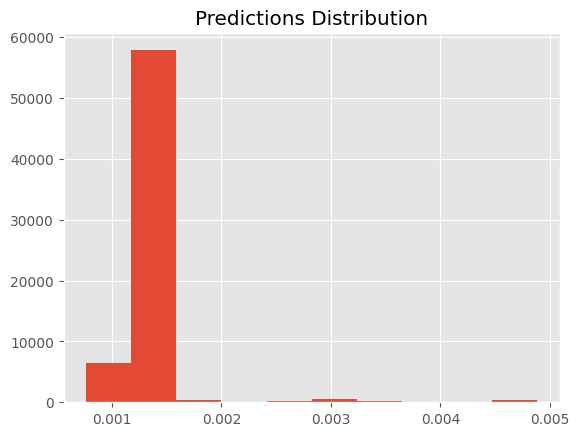

In [25]:
# Predictions histogram
plt.title("Predictions Distribution")
plt.hist(predictions)
plt.show()

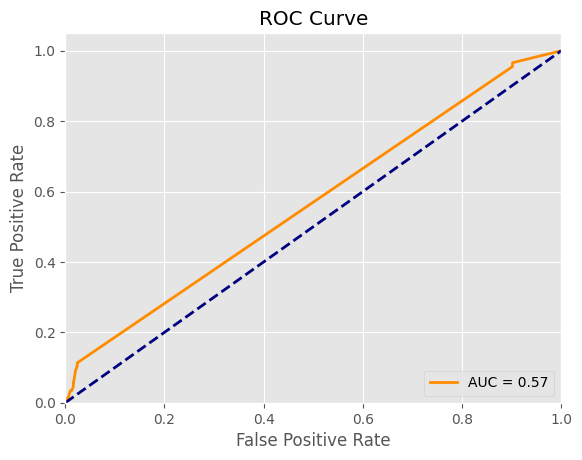

In [26]:
# Roc curve
fpr, tpr, _ = roc_curve(y_test, predictions)
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='AUC = %0.2f' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

LogisticRegression model: auc=0.009


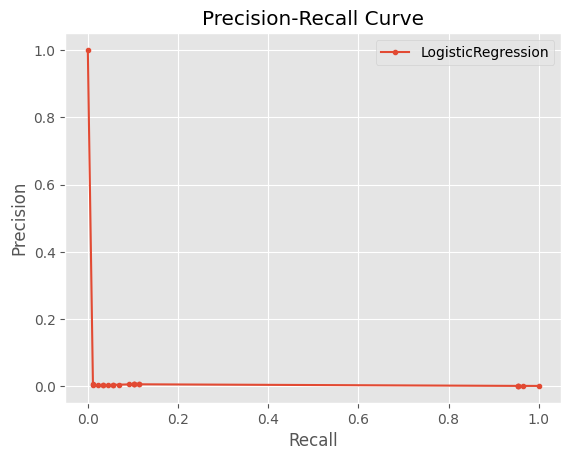

In [27]:
# Precision Recall Curve
precision, recall, _ = precision_recall_curve(y_test, predictions)

model_auc = auc(recall, precision)

# summarize scores
print('LogisticRegression model: auc=%.3f' % (model_auc))

# plot the precision-recall curves
plt.plot(recall, precision, marker='.', label="LogisticRegression")
# axis labels
plt.title("Precision-Recall Curve")
plt.xlabel('Recall')
plt.ylabel('Precision')
# show the legend
plt.legend()
# show the plot
plt.show()

 ## Reference
- [Precision Recall Curve](https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/)